#Phish Detection as Image Classification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports


In [ ]:
# You may import additional packages as appropriate
from __future__ import print_function
from __future__ import division

import math
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
from PIL import Image
import os
import torchvision.transforms as transforms
import multiprocessing as mp
import h5py

from collections import Counter
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, invert_permutation
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sn

%matplotlib inline
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.rcParams['font.size'] = 10

###Basics


In [ ]:
data_dir = '/content/drive/MyDrive/LogoDetection/phishIRIS_DL_Dataset/'
train_images_dir = data_dir+"train/"
val_images_dir = data_dir+"val/"


pickle_dir = '/content/drive/MyDrive/LogoDetection/phishIRIS_DL_Dataset_pickles/'
train_pickle_dir = pickle_dir+'train/'
val_pickle_dir = pickle_dir+'val/'


hdf5_dir = '/content/drive/MyDrive/LogoDetection/phishIRIS_DL_Dataset_hdf5/'

In [ ]:
labels = os.listdir(train_images_dir)
label_map = { labels[i]: i for i in range(len(labels))}
index_map = { i: labels[i] for i in range(len(labels))}
#label_map
RESOLUTION = (256,256) #(200,200)

In [ ]:
def pickle_dump(filename, item):
  with open(pickle_dir+filename+".pickle", "wb") as pkl:
    pickle.dump(item,pkl)

def pickle_load(filename):
  with open(pickle_dir+filename+".pickle", "rb") as pkl:
    return pickle.load(pkl)


In [ ]:
index_map

{0: 'microsoft',
 1: 'apple',
 2: 'dropbox',
 3: 'paypal',
 4: 'boa',
 5: 'chase',
 6: 'dhl',
 7: 'facebook',
 8: 'wellsfargo',
 9: 'adobe',
 10: 'linkedin',
 11: 'other',
 12: 'amazon',
 13: 'alibaba',
 14: 'yahoo'}

##Generating Data

Saved the Phish-IRIS dataset on my google drive. Matplotlib can read and display pictures

In [ ]:
def from_file(filename, extension):
  img = Image.open(filename)
  img = img.resize(RESOLUTION).convert('RGB')
  tensor = transforms.ToTensor()(img)
  if tensor.max() != 1.0:
    print(f"\tNon-1 Max; {extension}: {tensor.max()}")
  return tensor

def from_pickle(filename):
  with open(filename, 'rb') as pickled:
    return pickle.load(pickled)
   

def to_pickle(image, path, new_file):
  tensor = from_file(image)
  if not os.path.exists(path):
    os.makedirs(path)

  with open(path+new_file, 'wb') as pkl:
    pickle.dump(tensor,pkl)
  try:
    with open(path+new_file, "rb") as f:
      return pickle.load(f)
  except FileNotFoundError:
    print("Open error")
    return None

Reads each training image into memory, into a list of [3, 600, 600] tensors

###Training Data


In [ ]:
labels = os.listdir(train_images_dir)
train_images = []
train_labels = []
for label in labels:
  label_dir = train_images_dir+label+"/"
  files = os.listdir(label_dir)
  t0 = dt.datetime.now()
  print(f"Starting {label} at {dt.datetime.now()}")
  for image in files:
    name, imtype = image.split('.')
    train_images.append(from_file(label_dir+image, imtype))
    train_labels.append(label_map[label])
  print(f"\tLoaded {label} in {dt.datetime.now() - t0} seconds")

Starting microsoft at 2021-04-24 20:52:21.989883
	Loaded microsoft in 0:00:24.374891 seconds
Starting apple at 2021-04-24 20:52:46.367372
	Non-1 Max; png: 0.9647058844566345
	Loaded apple in 0:00:16.458135 seconds
Starting dropbox at 2021-04-24 20:53:02.827838
	Loaded dropbox in 0:00:20.186586 seconds
Starting paypal at 2021-04-24 20:53:23.018291
	Loaded paypal in 0:00:37.119629 seconds
Starting boa at 2021-04-24 20:54:00.141179
	Loaded boa in 0:00:24.508910 seconds
Starting chase at 2021-04-24 20:54:24.652925
	Loaded chase in 0:00:23.536068 seconds
Starting dhl at 2021-04-24 20:54:48.192092
	Loaded dhl in 0:00:20.368091 seconds
Starting facebook at 2021-04-24 20:55:08.562883
	Non-1 Max; png: 0.9960784316062927
	Non-1 Max; png: 0.9960784316062927
	Loaded facebook in 0:00:23.392654 seconds
Starting wellsfargo at 2021-04-24 20:55:31.958078
	Loaded wellsfargo in 0:00:24.700627 seconds
Starting adobe at 2021-04-24 20:55:56.660244
	Loaded adobe in 0:00:12.718394 seconds
Starting linkedin at

write all the images to an pickled tuple

In [ ]:
train_images = torch.stack(train_images)
train_labels = torch.tensor(train_labels)
train_images.shape, train_labels.shape

(torch.Size([1313, 3, 256, 256]), torch.Size([1313]))

In [ ]:
#with open(pickle_dir+f"train_data_{RESOLUTION[0]}.pickle", "wb") as pkl:
#  pickle.dump((train_images, train_labels),pkl)
pickle_dump(f"train_data_{RESOLUTION[0]}", (train_images, train_labels))

In [ ]:
with open(pickle_dir+f"train_data_{RESOLUTION[0]}.pickle", "rb") as pkl:
  train_images, train_labels = pickle.load(pkl)

microsoft


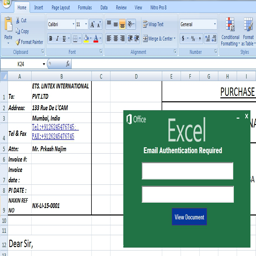

In [ ]:
print(index_map[train_labels[0].item()])
transforms.ToPILImage()(train_images[0])

###Validation Data and Test Data
Repeat process with val images, split half into test set

In [ ]:

labels = os.listdir(val_images_dir)
val_images = []
val_labels = []
for label in labels:
  label_dir = val_images_dir+label+"/"
  files = os.listdir(label_dir)
  t0 = dt.datetime.now()
  print(f"Starting {label} at {dt.datetime.now()}")
  for image in files:
    name, imtype = image.split('.')
    val_images.append(from_file(label_dir+image, imtype))
    val_labels.append(label_map[label])
  print(f"\tLoaded {label} in {dt.datetime.now() - t0} seconds")

Starting alibaba at 2021-04-24 20:59:10.791825
	Loaded alibaba in 0:00:07.779870 seconds
Starting linkedin at 2021-04-24 20:59:18.574325
	Loaded linkedin in 0:00:05.173145 seconds
Starting microsoft at 2021-04-24 20:59:23.749627
	Non-1 Max; png: 0.7215686440467834
	Loaded microsoft in 0:00:15.550592 seconds
Starting dhl at 2021-04-24 20:59:39.302340
	Loaded dhl in 0:00:11.966396 seconds
Starting boa at 2021-04-24 20:59:51.270827
	Loaded boa in 0:00:08.060948 seconds
Starting paypal at 2021-04-24 20:59:59.334242
	Loaded paypal in 0:00:26.451164 seconds
Starting adobe at 2021-04-24 21:00:25.787420
	Loaded adobe in 0:00:07.704707 seconds
Starting apple at 2021-04-24 21:00:33.493785
	Loaded apple in 0:00:03.554548 seconds
Starting yahoo at 2021-04-24 21:00:37.049803
	Loaded yahoo in 0:00:09.643198 seconds
Starting dropbox at 2021-04-24 21:00:46.695061
	Loaded dropbox in 0:00:10.357161 seconds
Starting amazon at 2021-04-24 21:00:57.054049
	Loaded amazon in 0:00:03.156837 seconds
Starting ch

In [ ]:
val_images = torch.stack(val_images)
val_labels = torch.tensor(val_labels)
val_images.shape, val_labels.shape

(torch.Size([1539, 3, 256, 256]), torch.Size([1539]))

alibaba


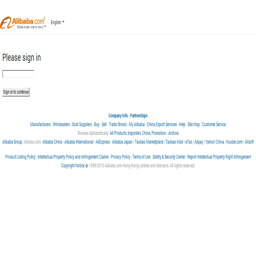

In [ ]:
print(index_map[val_labels[0].item()])
transforms.ToPILImage()(val_images[0])

#### Test Set
Put half the val data aside as test data(every other item)

In [ ]:
validation_images = val_images[::2]
test_images = val_images[1::2]
validation_labels = val_labels[::2]
test_labels = val_labels[1::2]
validation_images.shape, validation_labels.shape, test_images.shape, test_labels.shape

(torch.Size([770, 3, 256, 256]),
 torch.Size([770]),
 torch.Size([769, 3, 256, 256]),
 torch.Size([769]))

In [ ]:
with open(pickle_dir+f"val_data_{RESOLUTION[0]}.pickle", "wb") as pkl:
  pickle.dump((validation_images, validation_labels),pkl)
with open(pickle_dir+f"test_data_{RESOLUTION[0]}.pickle", "wb") as pkl:
  pickle.dump((test_images, test_labels),pkl)

In [ ]:
pickle_dump(f"val_data_{RESOLUTION[0]}", (validation_images, validation_labels))
pickle_dump(f"test_data_{RESOLUTION[0]}", (test_images, test_labels))

load pickles, make sure they both only contain half the validation images

In [ ]:
with open(pickle_dir+f"val_data_{RESOLUTION[0]}.pickle", "rb") as pkl:
  val_images, val_labels = pickle.load(pkl)
with open(pickle_dir+f"test_data_{RESOLUTION[0]}.pickle", "rb") as pkl:
  test_images, test_labels = pickle.load(pkl)
val_images.shape, val_labels.shape, test_images.shape, test_labels.shape

(torch.Size([770, 3, 256, 256]),
 torch.Size([770]),
 torch.Size([769, 3, 256, 256]),
 torch.Size([769]))

In [ ]:
#set default pickles to current resolution
pickle_dump("train_data", pickle_load(f"train_data_{RESOLUTION[0]}"))
pickle_dump("val_data", pickle_load(f"val_data_{RESOLUTION[0]}"))
pickle_dump("test_data", pickle_load(f"test_data_{RESOLUTION[0]}"))

##Dataloaders


In [ ]:
class ImageDataset(Dataset):
  def __init__(self, images, labels):
    self.X = images
    self.y = labels
        
  def __len__(self):
    return self.y.shape[0]
  
  def __getitem__(self, i):
    return self.X[i], self.y[i]

In [ ]:
def get_data_loader(batch_size):
  """
  Build vocabulary and prepare data.
  """
  

  with open(pickle_dir+"train_data.pickle", "rb") as pkl:
    train_images, train_labels = pickle.load(pkl)
  with open(pickle_dir+"val_data.pickle", "rb") as pkl:
    val_images, val_labels = pickle.load(pkl)
  
  loader_kwargs = {
  'batch_size': batch_size,
  'shuffle': True,
  'num_workers': 4,
  'pin_memory': True,
  'drop_last': True,
  }

  train_set = ImageDataset(train_images, train_labels)
  val_set = ImageDataset(val_images, val_labels)

  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)

  
  return train_loader, val_loader

In [ ]:
def get_binary_data_loader(batch_size):
  """
  Build vocabulary and prepare data.
  """
  

  with open(pickle_dir+"train_data.pickle", "rb") as pkl:
    train_images, train_labels = pickle.load(pkl)
  with open(pickle_dir+"val_data.pickle", "rb") as pkl:
    val_images, val_labels = pickle.load(pkl)
  
  train_labels = torch.where(train_labels==label_map['other'], 0, 1)

  val_labels = torch.where(val_labels==label_map['other'], 0, 1)

  loader_kwargs = {
  'batch_size': batch_size,
  'shuffle': True,
  'num_workers': 4,
  'pin_memory': True,
  'drop_last': True,
  }

  train_set = ImageDataset(train_images, train_labels)
  val_set = ImageDataset(val_images, val_labels)

  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)

  
  return train_loader, val_loader

In [ ]:
def get_test_loader(batch_size):
  """
  Build vocabulary and prepare data.
  """
  

  with open(pickle_dir+"test_data.pickle", "rb") as pkl:
    test_images, test_labels = pickle.load(pkl)

  test_labels_binary = torch.where(test_labels==label_map['other'], 0, 1)

  loader_kwargs = {
  'batch_size': batch_size,
  'shuffle': True,
  'num_workers': 4,
  'pin_memory': True,
  'drop_last': True,
  }

  discrete_set = ImageDataset(test_images, test_labels)
  binary_set = ImageDataset(test_images, test_labels_binary)

  discrete_loader = DataLoader(discrete_set, **loader_kwargs)
  binary_loader = DataLoader(binary_set, **loader_kwargs)

  
  return discrete_loader, binary_loader

##Models

In [ ]:
class ConvPoolBlock(nn.Module):
    def __init__(self, in_features, out_features, num_conv):
        super(ConvPoolBlock, self).__init__()
        features = [in_features] + [out_features for _ in range(num_conv)]
        layers = []
        for i in range(len(features)-1):
            layers.append(nn.Conv2d(in_channels=features[i], out_channels=features[i+1], kernel_size=5, padding=2, bias=True))
            layers.append(nn.BatchNorm2d(num_features=features[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2, 2))
        self.op = nn.Sequential(*layers)
    def forward(self, x):
        return self.op(x)

In [ ]:
class CompanyClassifier(nn.Module):
  classes = labels
  result_map = {
      200: 25,
      256: 32
  }

  def __init__(self, loss_func = nn.CrossEntropyLoss):
    super().__init__()
    self.convs = nn.Sequential(
      ConvPoolBlock(3,32, 2),
      ConvPoolBlock(32, 64, 3),
      ConvPoolBlock(64, 128, 3)
    )
    linshape = CompanyClassifier.result_map[RESOLUTION[0]]
    self.linear = 128*linshape * linshape
    self.dense = nn.Sequential(
      nn.Linear(self.linear, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 15)    
    )
    self.loss_func = loss_func()

  def forward(self, images):
    """
    Run batch of images through the network

    images: [batch, 3, x, y] tensor of images
    output: [batch, 15] tensor of output values
    """
    x = self.convs(images)
    #print(f"conv output: {x.shape}")
    x = x.view(-1, self.linear)
    x = self.dense(x)
    return x
  

  def loss(self, images, labels):
    outputs = self.forward(images)
    batch_loss = self.loss_func(outputs, labels)

    return batch_loss
  
  def predict(self, images):
    labels_pred = None
    x = self.forward(images)
    labels_pred = x.max(dim=1).indices
    return labels_pred

In [ ]:
class PhishingClassifier(nn.Module):
  classes = labels

  def __init__(self, loss_func = nn.CrossEntropyLoss):
    super().__init__()
    self.network = nn.Sequential(
      CompanyClassifier(),
      nn.Linear(15,2)
    )
    self.loss_func = loss_func()
  
  def forward(self, images):
    return self.network(images)  

  def loss(self, images, labels):
    batch_loss = None

    outputs = self.forward(images)
    batch_loss = self.loss_func(outputs, labels)

    return batch_loss
  
  def predict(self, images):
    x = self.forward(images)

    labels_pred = x.max(dim=-1).indices
    return labels_pred

##Training

###functions

In [ ]:
def eval_acc(model, data_loader):
  
  with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0
    
    for (images, labels) in data_loader:
      images = images.cuda()
      labels = labels.cuda()
      
      labels_pred = model.predict(images)
      
      total += labels.shape[0]
      correct += (labels_pred == labels).sum().item()
    
    acc = 100 * correct / total
  
  return acc

In [ ]:
def train(model, train_loader, val_loader, num_epochs, learning_rate):
  
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  loss_history = []
  for epoch in range(num_epochs):
    val_acc = eval_acc(model, val_loader)
    
    model.train()
    for batch, data in enumerate(train_loader):
      data = [d.cuda() for d in data]
      
      optimizer.zero_grad()
      loss = model.loss(*data)

      loss.backward()
      clip_grad_norm_(model.parameters(), 1)  # gradient clipping
      optimizer.step()
      
      with torch.no_grad():
        loss_history.append(loss.item())
        if batch == 0:
          print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
            epoch, loss.item(), val_acc))
  
  return model, loss_history

In [ ]:
def print_stats(tp, fp, tn, fn):
  accuracy = (tp+tn)/(tp+fp+tn+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  tpr = recall
  fnr = fn/(fn+tp)
  tnr = tn/(tn+fp)

  fpr = fp/(fp+tn)
  
  print()
  print(f"Accuracy: {accuracy}")
  print(f"Recall: {recall}")
  print(f"Precision: {precision}")
  print()
  print(f"tpr: {tpr}")
  print(f"fnr: {fnr}")
  print(f"tnr: {tnr}")
  print(f"fpr: {fpr}")

def confusion_matrix(model, data_loader):
  get_confusion_matrix(model,data_loader)

def get_confusion_matrix(model, data_loader):
  with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0
    tp, fp, tn, fn = (0,0,0,0)

    run_pred, run_labels = ([],[])

    for (images, labels) in data_loader:


      images = images.cuda()
      labels = labels.cuda()
      
      labels_pred = model.predict(images)
      if(labels.max()>1):
        labels_pred = torch.where(labels_pred==label_map['other'], 0, 1).cuda()
        labels = torch.where(labels==label_map['other'], 0, 1).cuda()

      pos_guess = labels_pred
      neg_guess = torch.logical_not(labels_pred)
      pos_label = labels
      neg_label = torch.logical_not(labels)
      tp += torch.logical_and(pos_guess, pos_label).sum().item()
      fp += torch.logical_and(pos_guess, neg_label).sum().item()
      fn += torch.logical_and(neg_guess, pos_label).sum().item()
      tn += torch.logical_and(neg_guess, neg_label).sum().item()


      total += labels.shape[0]
      correct += (labels_pred == labels).sum().item()
      run_pred += labels_pred.tolist()
      run_labels += labels.tolist()


    acc = 100 * correct / total
    tp *= 100/total
    fp *= 100/total
    tn *= 100/total
    fn *= 100/total

  data = {'y_Actual': run_labels,
  'y_Predicted':  run_pred
  }

  print_stats(tp, fp, tn, fn)
  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix_df = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

  heatmap = sn.heatmap(confusion_matrix_df, annot=True, fmt = "d")
  heatmap.add_patch(Rectangle((0, 0), 1, 1, ec='green', fc='none', lw=4))
  heatmap.add_patch(Rectangle((1, 1), 1, 1, ec='green', fc='none', lw=4))
  heatmap.add_patch(Rectangle((0, 1), 1, 1, ec='red', fc='none', lw=4, ls = ":"))
  heatmap.add_patch(Rectangle((1, 0), 1, 1, ec='red', fc='none', lw=4, ls = ":"))

  plt.show()
  return tp, fp, tn, fn, data 

In [ ]:
def discrete_confusion_matrix(model, data_loader):
  get_discrete_confusion_matrix(model,data_loader)

def get_discrete_confusion_matrix(model, data_loader):
  with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0

    run_pred, run_labels = ([],[])

    for (images, labels) in data_loader:


      images = images.cuda()
      labels = labels.cuda()
      
      labels_pred = model.predict(images)

      total += labels.shape[0]
      correct += (labels_pred == labels).sum().item()
      run_pred += labels_pred.tolist()
      run_labels += labels.tolist()

  data = {'y_Actual': [index_map[x] for x in run_labels],#run_labels,
  'y_Predicted':  [index_map[x] for x in run_pred]#run_pred
  }

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix_df = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

  heatmap = sn.heatmap(confusion_matrix_df, annot=True, fmt = "d")
  heatmap.add_patch(Rectangle((11, 11), 1, 1, ec='green', fc='none', lw=2))
  #heatmap.add_patch(Rectangle((1, 1), 1, 1, ec='green', fc='none', lw=4))
  #heatmap.add_patch(Rectangle((0, 1), 1, 1, ec='red', fc='none', lw=4, ls = ":"))
  #heatmap.add_patch(Rectangle((1, 0), 1, 1, ec='red', fc='none', lw=4, ls = ":"))

  plt.show()
  return data 

###15 Class Classifier

Roughly 64% of validation items are of type 'other' Some models may always predict other

####Training


In [ ]:
torch.manual_seed(0)

batch_size = 25
discrete_train_loader, discrete_val_loader = get_data_loader(batch_size)

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 20
learning_rate = 3e-4

discrete_model = CompanyClassifier()
discrete_model = discrete_model.cuda()

discrete_model, loss_history = train(discrete_model, discrete_train_loader, discrete_val_loader, num_epochs, learning_rate)

In [ ]:
pickle_dump("discrete_model", discrete_model)

####Evaluation

In [ ]:
confusion_matrix(discrete_model,discrete_train_loader)

In [ ]:
confusion_matrix(discrete_model,discrete_val_loader)

###Binary Classifier
Same potential problem as before

####Training

In [ ]:
torch.manual_seed(0)

batch_size = 25
binary_train_loader, binary_val_loader = get_binary_data_loader(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
num_epochs = 20
learning_rate = 3e-4
   
binary_model = PhishingClassifier()
binary_model = binary_model.cuda()

binary_model, loss_history = train(binary_model, binary_train_loader, binary_val_loader, num_epochs, learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch:   0 	 Loss: 0.680793 	 Val Acc: 35.066667
Train Epoch:   1 	 Loss: 0.444712 	 Val Acc: 39.733333
Train Epoch:   2 	 Loss: 0.754156 	 Val Acc: 47.733333
Train Epoch:   3 	 Loss: 0.436986 	 Val Acc: 74.000000
Train Epoch:   4 	 Loss: 0.459029 	 Val Acc: 78.800000
Train Epoch:   5 	 Loss: 0.324928 	 Val Acc: 75.333333
Train Epoch:   6 	 Loss: 0.425725 	 Val Acc: 82.133333
Train Epoch:   7 	 Loss: 0.505145 	 Val Acc: 69.600000
Train Epoch:   8 	 Loss: 0.269080 	 Val Acc: 62.000000
Train Epoch:   9 	 Loss: 0.321811 	 Val Acc: 76.133333
Train Epoch:  10 	 Loss: 0.129704 	 Val Acc: 73.200000
Train Epoch:  11 	 Loss: 0.492444 	 Val Acc: 63.866667
Train Epoch:  12 	 Loss: 0.242255 	 Val Acc: 80.133333
Train Epoch:  13 	 Loss: 0.288853 	 Val Acc: 70.000000
Train Epoch:  14 	 Loss: 0.095046 	 Val Acc: 82.933333
Train Epoch:  15 	 Loss: 0.051309 	 Val Acc: 84.800000
Train Epoch:  16 	 Loss: 0.239167 	 Val Acc: 66.666667
Train Epoch:  17 	 Loss: 0.108431 	 Val Acc: 70.266667
Train Epoc

In [ ]:
pickle_dump("binary_model", binary_model)

####Evaluation

In [ ]:
confusion_matrix(binary_model, binary_train_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Accuracy: 0.8293333333333334
Recall: 0.8022813688212929
Precision: 0.735191637630662

tpr: 0.8022813688212929
fnr: 0.19771863117870725
tnr: 0.8439425051334701
fpr: 0.15605749486652976


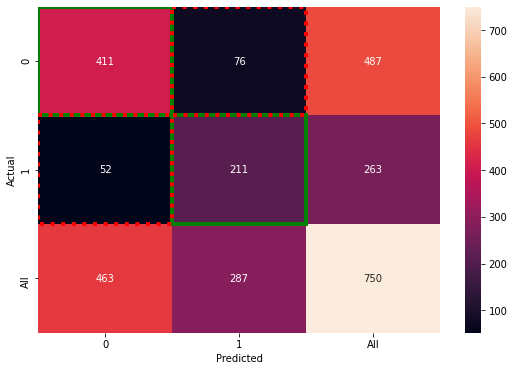

In [ ]:
confusion_matrix(binary_model, binary_val_loader)

## Improve with Attention

###Model

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_features, out_features, num_conv, pool=False):
    super(ConvBlock, self).__init__()
    features = [in_features] + [out_features for i in range(num_conv)]
    layers = []
    for i in range(len(features)-1):
      layers.append(nn.Conv2d(in_channels=features[i], out_channels=features[i+1], kernel_size=3, padding=1, bias=True))
      layers.append(nn.BatchNorm2d(num_features=features[i+1], affine=True, track_running_stats=True))
      layers.append(nn.ReLU())
      if pool:
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
    self.op = nn.Sequential(*layers)
  def forward(self, x):
    return self.op(x)


class ProjectorBlock(nn.Module):
  def __init__(self, in_features, out_features):
    super(ProjectorBlock, self).__init__()
    self.op = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=1, padding=0, bias=False)
  def forward(self, inputs):
    return self.op(inputs)

class LinearAttentionBlock(nn.Module):
    def __init__(self, in_features, normalize_attn=True):
        super(LinearAttentionBlock, self).__init__()
        self.normalize_attn = normalize_attn
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1, kernel_size=1, padding=0, bias=False)
    def forward(self, l, g):
        N, C, W, H = l.size()
        c = self.op(l+g) # batch_sizex1xWxH
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        g = torch.mul(a.expand_as(l), l)
        if self.normalize_attn:
            g = g.view(N,C,-1).sum(dim=2) # batch_sizexC
        else:
            g = F.adaptive_avg_pool2d(g, (1,1)).view(N,C)
        return c.view(N,1,W,H), g

def weights_init_xavierUniform(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=np.sqrt(2))
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

In [ ]:
class AttentionVGG(nn.Module):
  def __init__(self, im_size = RESOLUTION[0], num_classes = 15, loss_func = nn.CrossEntropyLoss):
    super(AttentionVGG, self).__init__()
    # conv blocks
    #start = 16 #64
    #small, medium, large, final = [start**i for i in range(1, 5)]
    self.conv_block1 = ConvBlock(3, 64, 2)
    self.conv_block2 = ConvBlock(64, 128, 2)
    self.conv_block3 = ConvBlock(128, 256, 3)
    self.conv_block4 = ConvBlock(256, 512, 3)
    self.conv_block5 = ConvBlock(512, 512, 3)
    self.conv_block6 = ConvBlock(512, 512, 2, pool=True)
    self.dense = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=int(im_size/32), padding=0, bias=True)
    # Projectors & Compatibility functions
    self.projector = ProjectorBlock(256, 512)
    self.attn1 = LinearAttentionBlock(in_features=512)
    self.attn2 = LinearAttentionBlock(in_features=512)
    self.attn3 = LinearAttentionBlock(in_features=512)
    self.classify = nn.Linear(in_features=512*3, out_features=num_classes, bias=True)
    self.loss_func = loss_func()
    weights_init_xavierUniform(self)

  def forward(self, x):
    # feed forward
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    l1 = self.conv_block3(x) # /1
    x = F.max_pool2d(l1, kernel_size=2, stride=2, padding=0) # /2
    l2 = self.conv_block4(x) # /2
    x = F.max_pool2d(l2, kernel_size=2, stride=2, padding=0) # /4
    l3 = self.conv_block5(x) # /4
    x = F.max_pool2d(l3, kernel_size=2, stride=2, padding=0) # /8
    x = self.conv_block6(x) # /32
    g = self.dense(x) # batch_sizex512x1x1
    # pay attention
    c1, g1 = self.attn1(self.projector(l1), g)
    c2, g2 = self.attn2(l2, g)
    c3, g3 = self.attn3(l3, g)
    g = torch.cat((g1,g2,g3), dim=1) # batch_sizexC
    # classification layer
    x = self.classify(g) # batch_sizexnum_classes
    return x, c1, c2, c3

  def loss(self, images, labels):
    outputs, _, _, _ = self.forward(images)

    batch_loss = self.loss_func(outputs, labels)
    # END OF YOUR CODE
    return batch_loss

  def predict(self, images):
    outputs, _, _, _ = self.forward(images)

    labels_pred = outputs.max(dim=1).indices
    return labels_pred


In [ ]:
class AttentionLite(nn.Module):
  def __init__(self, im_size = RESOLUTION[0], num_classes = 15, loss_func = nn.CrossEntropyLoss):
    super(AttentionLite, self).__init__()
    # conv blocks
    #start = 16 #64
    #small, medium, large, final = [start**i for i in range(1, 5)]
    self.conv_block1 = ConvBlock(3, 16, 2)
    self.conv_block2 = ConvBlock(16, 32, 2)
    self.conv_block3 = ConvBlock(32, 64, 3)
    self.conv_block4 = ConvBlock(64, 128, 3)
    self.conv_block5 = ConvBlock(128, 128, 3)
    self.conv_block6 = ConvBlock(128, 128, 2, pool=True)
    self.dense = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=int(im_size/32), padding=0, bias=True)
    # Projectors & Compatibility functions
    self.projector = ProjectorBlock(64, 128)
    self.attn1 = LinearAttentionBlock(in_features=128)
    self.attn2 = LinearAttentionBlock(in_features=128)
    self.attn3 = LinearAttentionBlock(in_features=128)
    self.classify = nn.Linear(in_features=128*3, out_features=num_classes, bias=True)
    self.loss_func = loss_func()
    weights_init_xavierUniform(self)

  def forward(self, x):
    # feed forward
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    l1 = self.conv_block3(x) # /1
    x = F.max_pool2d(l1, kernel_size=2, stride=2, padding=0) # /2
    l2 = self.conv_block4(x) # /2
    x = F.max_pool2d(l2, kernel_size=2, stride=2, padding=0) # /4
    l3 = self.conv_block5(x) # /4
    x = F.max_pool2d(l3, kernel_size=2, stride=2, padding=0) # /8
    x = self.conv_block6(x) # /32
    g = self.dense(x) # batch_sizex512x1x1
    # pay attention
    c1, g1 = self.attn1(self.projector(l1), g)
    c2, g2 = self.attn2(l2, g)
    c3, g3 = self.attn3(l3, g)
    g = torch.cat((g1,g2,g3), dim=1) # batch_sizexC
    # classification layer
    x = self.classify(g) # batch_sizexnum_classes
    return x, c1, c2, c3

  def loss(self, images, labels):
    outputs, _, _, _ = self.forward(images)

    batch_loss = self.loss_func(outputs, labels)
    # END OF YOUR CODE
    return batch_loss

  def predict(self, images):
    outputs, _, _, _ = self.forward(images)

    labels_pred = outputs.max(dim=1).indices
    return labels_pred


### Improved VGG

####Training


In [ ]:
torch.manual_seed(0)

batch_size = 6
discrete_train_loader, discrete_val_loader = get_data_loader(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
num_epochs = 20
learning_rate = 1e-4

attention_model = AttentionVGG()
attention_model = attention_model.cuda()

attention_model, loss_history = train(attention_model, discrete_train_loader, discrete_val_loader, num_epochs, learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch:   0 	 Loss: 2.421978 	 Val Acc: 2.734375
Train Epoch:   1 	 Loss: 1.675560 	 Val Acc: 67.447917
Train Epoch:   2 	 Loss: 2.927589 	 Val Acc: 65.104167
Train Epoch:   3 	 Loss: 1.298622 	 Val Acc: 74.479167
Train Epoch:   4 	 Loss: 1.688530 	 Val Acc: 75.390625
Train Epoch:   5 	 Loss: 0.634306 	 Val Acc: 74.609375
Train Epoch:   6 	 Loss: 1.304219 	 Val Acc: 77.734375
Train Epoch:   7 	 Loss: 0.755811 	 Val Acc: 81.510417
Train Epoch:   8 	 Loss: 0.817529 	 Val Acc: 71.354167
Train Epoch:   9 	 Loss: 0.070370 	 Val Acc: 76.692708
Train Epoch:  10 	 Loss: 0.823258 	 Val Acc: 71.614583
Train Epoch:  11 	 Loss: 0.024453 	 Val Acc: 82.421875
Train Epoch:  12 	 Loss: 0.147069 	 Val Acc: 85.937500
Train Epoch:  13 	 Loss: 0.734517 	 Val Acc: 75.260417
Train Epoch:  14 	 Loss: 0.100750 	 Val Acc: 81.510417
Train Epoch:  15 	 Loss: 0.017405 	 Val Acc: 78.385417
Train Epoch:  16 	 Loss: 0.821887 	 Val Acc: 87.239583
Train Epoch:  17 	 Loss: 0.004563 	 Val Acc: 82.942708
Train Epoch

In [ ]:
num_epochs = 1
attention_model, loss_history = train(attention_model, discrete_train_loader, discrete_val_loader, num_epochs, learning_rate)
eval_acc(attention_model, discrete_val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch:   0 	 Loss: 0.272959 	 Val Acc: 88.541667


82.94270833333333

In [ ]:
pickle_dump("attention_model_original", attention_model)

####Evaluation

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Accuracy: 0.9655963302752292
Recall: 0.9779977997799779
Precision: 0.9726477024070023

tpr: 0.9779977997799779
fnr: 0.022002200220022004
tnr: 0.9373433583959899
fpr: 0.06265664160401002


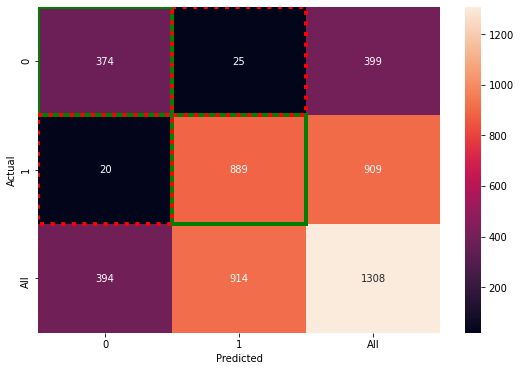

In [ ]:
confusion_matrix(attention_model,discrete_train_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Accuracy: 0.8658854166666666
Recall: 0.862962962962963
Precision: 0.7792642140468227

tpr: 0.862962962962963
fnr: 0.13703703703703704
tnr: 0.8674698795180724
fpr: 0.13253012048192772


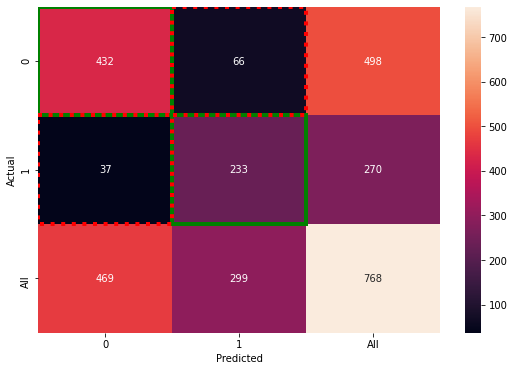

In [ ]:
confusion_matrix(attention_model,discrete_val_loader)

##Test on Test Set

In [ ]:
torch.manual_seed(0)

batch_size = 6
discrete_test_loader, binary_test_loader = get_test_loader(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Accuracy: 0.8502604166666667
Recall: 0.7276119402985075
Precision: 0.8227848101265823

tpr: 0.7276119402985075
fnr: 0.27238805970149255
tnr: 0.916
fpr: 0.08399999999999999


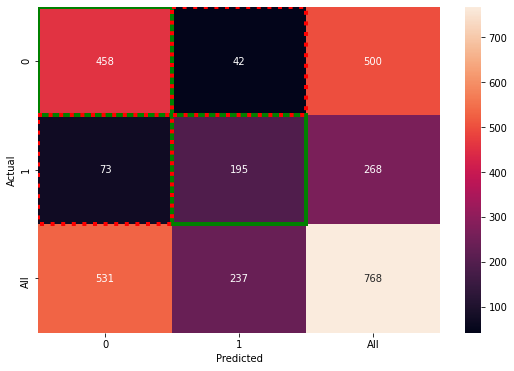

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


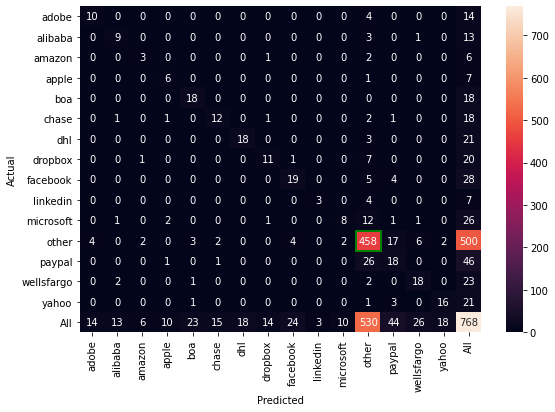

In [ ]:
discrete_model = pickle_load("discrete_model")
confusion_matrix(discrete_model,discrete_test_loader)
discrete_confusion_matrix(discrete_model,discrete_test_loader)
del discrete_model

In [ ]:
binary_model = pickle_load("binary_model")
confusion_matrix(binary_model,binary_test_loader)
del binary_model

In [ ]:
torch.manual_seed(0)

batch_size = 15
discrete_test_loader, binary_test_loader = get_test_loader(batch_size)
attention_model = pickle_load("attention_model")
confusion_matrix(attention_model,discrete_test_loader)
discrete_confusion_matrix(attention_model,discrete_test_loader)
del attention_model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Accuracy: 0.8932291666666666
Recall: 0.8246268656716418
Precision: 0.86328125

tpr: 0.8246268656716418
fnr: 0.17537313432835822
tnr: 0.93
fpr: 0.06999999999999999


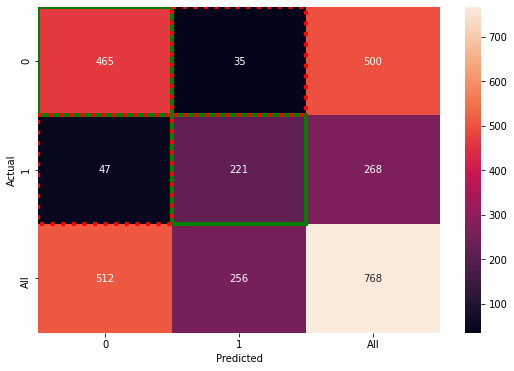

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


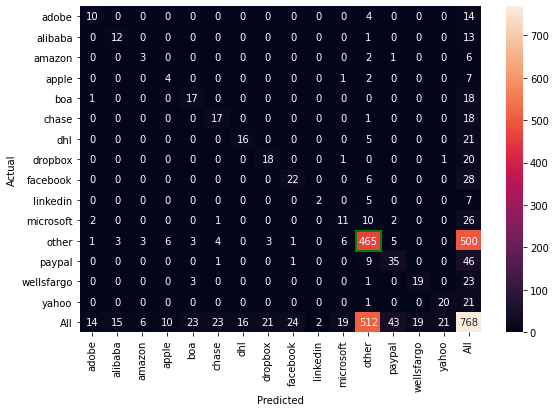

In [ ]:
torch.manual_seed(0)

batch_size = 6
discrete_test_loader, binary_test_loader = get_test_loader(batch_size)
attention_model = pickle_load("attention_model_original")
confusion_matrix(attention_model,discrete_test_loader)
discrete_confusion_matrix(attention_model,discrete_test_loader)
del attention_model